# CIR

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import default_rng, SeedSequence

In [3]:
sq = SeedSequence()
rng = default_rng(sq)
idx = pd.IndexSlice

In [4]:
from scheme import *
from errors import *

# Strong errors

In [5]:
params = {
    'x0': 1,
    'a': 1,
    'k': 1,
    'sigma': 1,
    'T':1,
    'lambdaa': 1/8
    
}
schemaTypes = ["implicit_3", "implicit_4", "E_lambda", "E_0", "Diop", "D-D"]

In [6]:
scheme = CIR(**params)

In [7]:
step_width = np.linspace(0.0001,0.01,20)
steps = np.round(1/step_width).astype(int)

In [8]:
"""
    Computes the strong error for various discretization step
    for various scheme types
"""
steps = [100*i for i in range(1,20)]
result_strong_error = pd.DataFrame(index= steps)
result_strong_error['step_width'] = 1/result_strong_error.index
for type in schemaTypes:
    result_strong_error[type] = strong_error(scheme, scheme_type= type, steps= steps)[:,0]

<Axes: xlabel='step_width'>

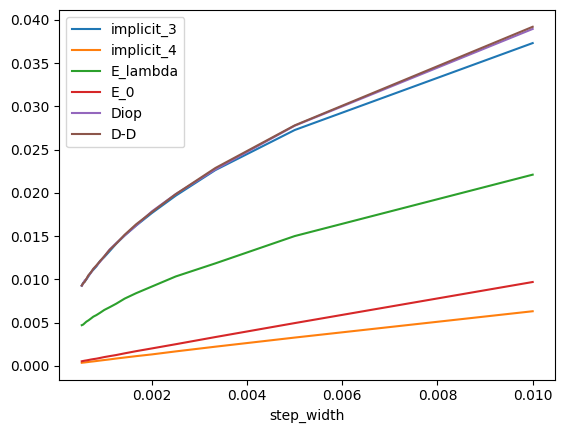

In [9]:
result_strong_error.set_index(['step_width']).plot()

## Speed convergence


In [10]:
params = {
    'x0': 0,
    'a': 1,
    'k': 1,
    # "sigma": np.sqrt(3) bug implicit3
    'sigma': 1,
    'T':1,
    'lambdaa': 1/8,
}

In [11]:
scheme = CIR(**params)

In [12]:
step_width = np.linspace(0.01,2.5,25)
sigma_grid = step_width**2 / 2

In [13]:
"""
    Computes the speed of convergence for various scheme types 
    with a discretization step of 1/200
""" 
result_speed_convergence = pd.DataFrame(index=sigma_grid)
for type in schemaTypes:
    result_speed_convergence[type] = speed_convergence(scheme, type, N = 200)

c:\Users\xziru\OneDrive - Ecole Polytechnique\Paris 6\période 2\projet Monte-Carlos\project-Monte-Carlo\scheme.py:51: RuntimeWarning: invalid value encountered in sqrt
  val = ((self.sigma*dW[n-1] + np.sqrt(self.sigma**2 * (dW[n-1])**2 + 4 * (x[n-1] + (self.a - 0.5*self.sigma**2)*h) * (1 + self.k*h)))/(2*(1+self.k*h))) ** 2
c:\Users\xziru\OneDrive - Ecole Polytechnique\Paris 6\période 2\projet Monte-Carlos\project-Monte-Carlo\scheme.py:62: RuntimeWarning: invalid value encountered in sqrt
  val = ((0.5*self.sigma*dW[n-1] + np.sqrt(x[n-1]) + np.sqrt((0.5*self.sigma * dW[n-1] + np.sqrt(x[n-1]))**2 + 4 * ((self.a*0.5 - 0.125*self.sigma**2)*h) * (1 + 0.5*self.k*h)))/(2*(1+ 0.5*self.k*h))) ** 2


<Axes: >

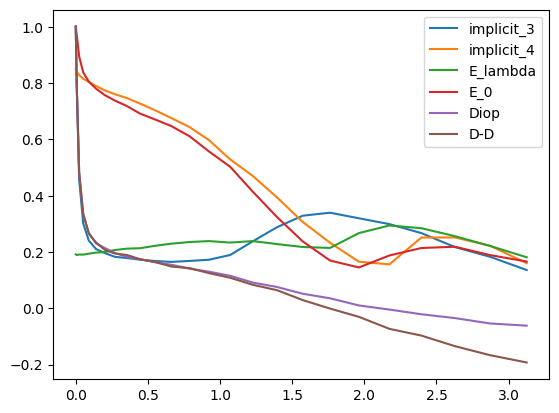

In [14]:
result_speed_convergence.plot()

# weak errors

In [15]:
params = {
    'x0': 0,
    'a': 1,
    'k': 1,
    # "sigma": np.sqrt(3) bug implicit3
    'sigma': 1,
    'T':1,
    'lambdaa': 1/8,
}

In [16]:
scheme = CIR(**params)
schemaTypes = ["implicit_3", "implicit_4", "E_lambda", "E_0", "Diop", "D-D"]

In [17]:
step_width = np.linspace(0.001,0.1,20)
steps = np.round(1/step_width).astype(int)

In [18]:
result_weak_error = (pd.DataFrame(index= step_width, 
                                   columns=pd.MultiIndex.from_product([ schemaTypes,['normal','double','extrapolation']]),
                                   dtype= float))


In [19]:
"""
    Computes the weak error for various discretization step
    for various scheme types, with a chosen function
"""
for type in schemaTypes:
    tem = weak_error(lambda x: (5 + 3*x**4)/(2 + 5*x),scheme, scheme_type= type, steps= steps,M = int(1e5))
    result_weak_error.loc[:,idx[type,:]] = tem

Text(0.5, 1.0, 'the weak convergence result by using exprapolation')

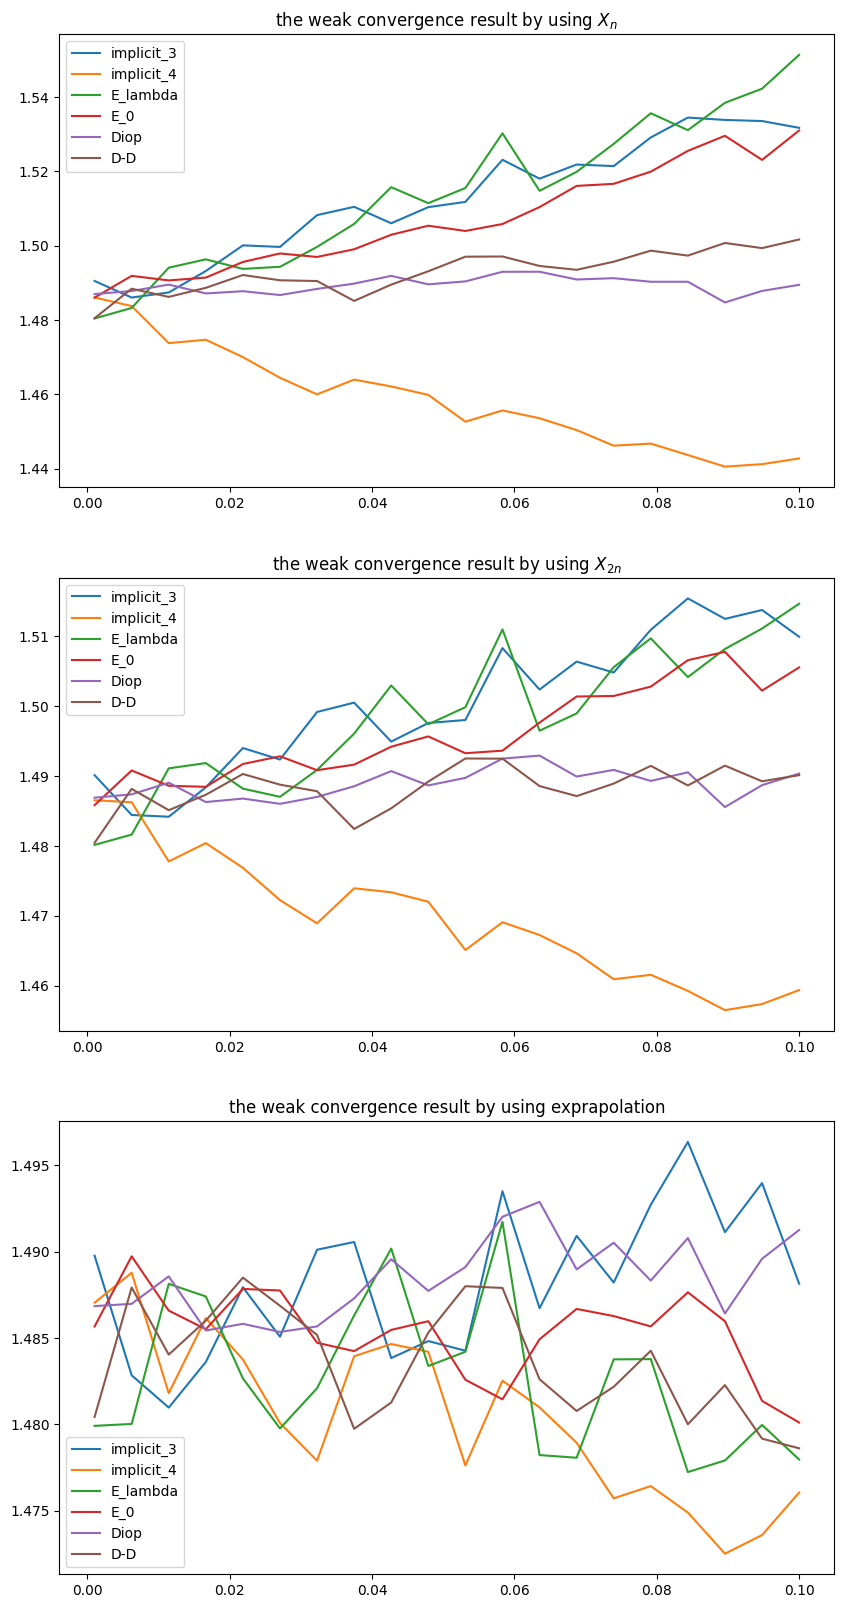

In [37]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize = (10,20))
result_weak_error.loc[:,idx[:,'normal']].droplevel(1, axis = 1).plot(ax = ax1)
ax1.set_title('the weak convergence result by using $X_n$')
result_weak_error.loc[:,idx[:,'double']].droplevel(1, axis = 1).plot(ax = ax2)
ax2.set_title('the weak convergence result by using $X_{2n}$')
result_weak_error.loc[:,idx[:,'extrapolation']].droplevel(1, axis = 1).plot(ax = ax3)
ax3.set_title('the weak convergence result by using exprapolation')




## Aggregate version for weak convergence

* This part is used to generate a large number of samples $M\geq 1e6$ to reduce the estimation variance, note that the code above can have memory errors when take $M\geq 1e5$

In [39]:
"""
Instead of simulating 1e6 samples and computing the mean, we regroup the 1e6 samples in 10 groups, 
then we compute the mean for each group and the overal mean as the mean of the mean of each group  
"""

results_weak_errors = []
n_iters = 10
for i in range(n_iters):
    result_weak_error = (pd.DataFrame(index= step_width, 
                                   columns=pd.MultiIndex.from_product([ schemaTypes,['normal','double','extrapolation']]),
                                   dtype= float))
    for type in schemaTypes:
        tem = weak_error(lambda x: (5 + 3*x**4)/(2 + 5*x),scheme, scheme_type= type, steps= steps,M = int(1e5))
        result_weak_error.loc[:,idx[type,:]] = tem
    
    results_weak_errors.append(result_weak_error)

result_weak_error_agg = sum(results_weak_errors)/n_iters


Text(0.5, 1.0, 'weak convergence result for $X_2n$')

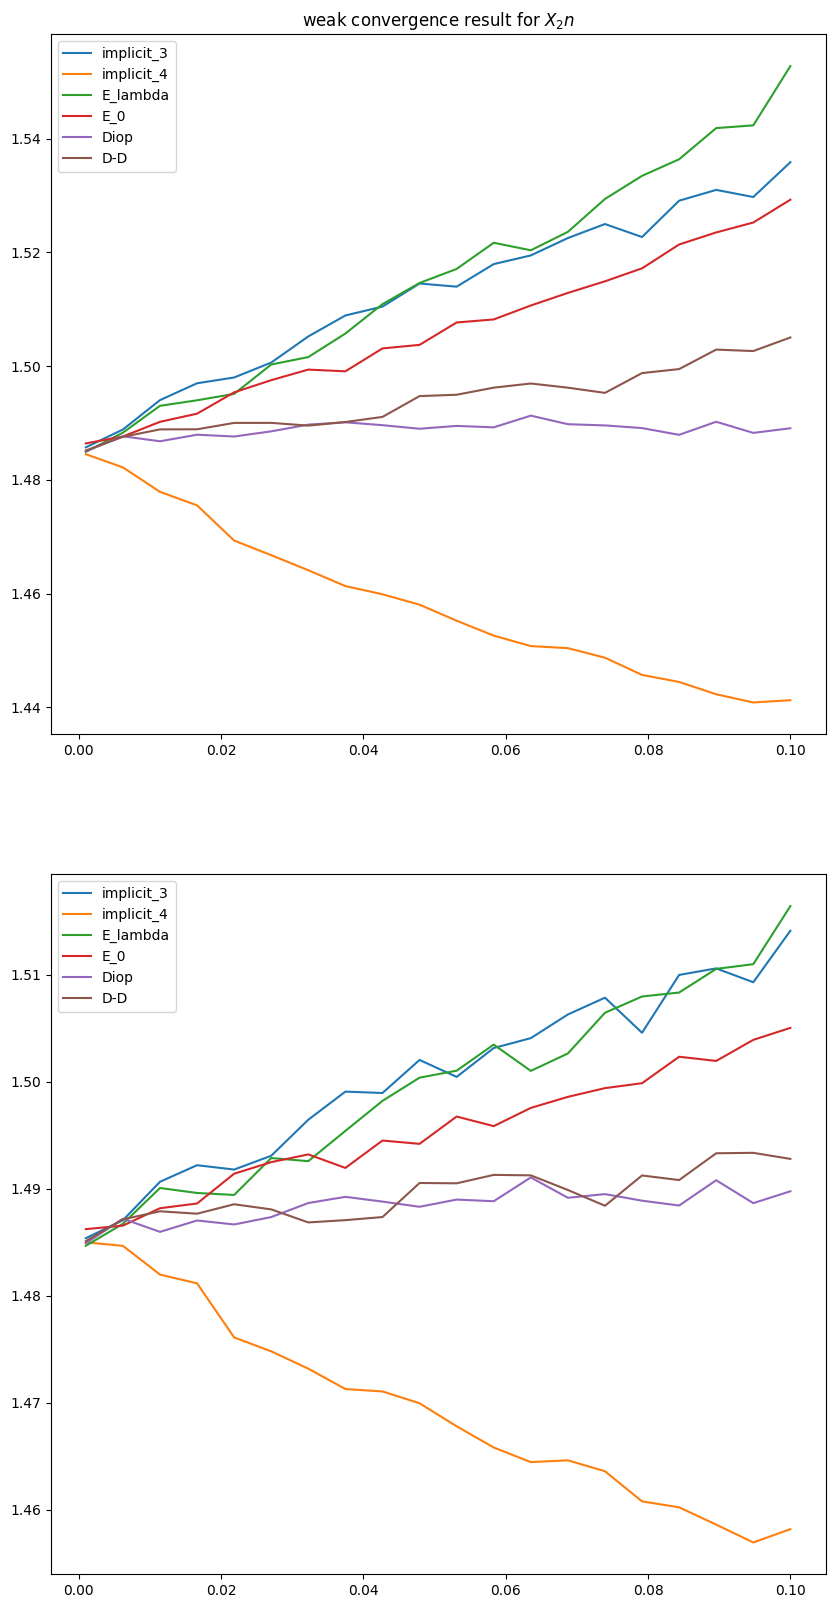

In [38]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (10,20))
result_weak_error_agg.loc[:,idx[:,'normal']].droplevel(1, axis = 1).plot(ax = ax1)
ax1.set_title('weak convergence result for $X_n$')
result_weak_error_agg.loc[:,idx[:,'double']].droplevel(1, axis = 1).plot(ax = ax2)
ax1.set_title('weak convergence result for $X_2n$')

In [22]:
result_weak_error_agg

implicit_3                         implicit_4            \
             normal    double extrapolation     normal    double   
0.001000   1.485706  1.485382      1.485057   1.484500  1.484994   
0.006211   1.488838  1.487061      1.485283   1.482180  1.484668   
0.011421   1.494010  1.490652      1.487295   1.477882  1.481985   
0.016632   1.496972  1.492201      1.487430   1.475504  1.481165   
0.021842   1.497990  1.491794      1.485599   1.469315  1.476112   
0.027053   1.500614  1.493083      1.485553   1.466746  1.474812   
0.032263   1.505208  1.496451      1.487695   1.464097  1.473192   
0.037474   1.508893  1.499076      1.489259   1.461311  1.471292   
0.042684   1.510454  1.498947      1.487440   1.459870  1.471066   
0.047895   1.514513  1.502034      1.489554   1.458044  1.469961   
0.053105   1.513957  1.500451      1.486944   1.455223  1.467811   
0.058316   1.517925  1.503146      1.488367   1.452603  1.465830   
0.063526   1.519450  1.504071      1.488692   1.450760  1.464463   
0.068737   1.522509  1.506283      1.490057   1.450399  1.464631   
0.073947   1.524969  1.507850      1.490731   1.448719  1.463611   
0.079158   1.522685  1.504572      1.486459   1.445690  1.460796   
0.084368   1.529074  1.509978      1.490881   1.444456  1.460242   
0.089579   1.530974  1.510587      1.490200   1.442291  1.458623   
0.094789   1.529721  1.509291      1.488862   1.440849  1.456957   
0.100000   1.535840  1.514106      1.492373   1.441244  1.458201   

                        E_lambda                               E_0            \
         extrapolation    normal    double extrapolation    normal    double   
0.001000      1.485488  1.484909  1.484673      1.484437  1.486399  1.486229   
0.006211      1.487156  1.488285  1.486727      1.485169  1.487613  1.486556   
0.011421      1.486087  1.493010  1.490072      1.487135  1.490194  1.488181   
0.016632      1.486827  1.493980  1.489605      1.485231  1.491624  1.488624   
0.021842      1.482909  1.495104  1.489422      1.483740  1.495373  1.491408   
0.027053      1.482877  1.500268  1.492870      1.485473  1.497517  1.492487   
0.032263      1.482286  1.501581  1.492578      1.483576  1.499377  1.493210   
0.037474      1.481272  1.505716  1.495408      1.485100  1.499073  1.491948   
0.042684      1.482261  1.510887  1.498210      1.485534  1.503099  1.494505   
0.047895      1.481879  1.514604  1.500380      1.486156  1.503724  1.494197   
0.053105      1.480398  1.517078  1.501032      1.484987  1.507662  1.496749   
0.058316      1.479057  1.521675  1.503469      1.485264  1.508195  1.495851   
0.063526      1.478165  1.520355  1.501014      1.481673  1.510644  1.497554   
0.068737      1.478862  1.523592  1.502639      1.481686  1.512857  1.498585   
0.073947      1.478503  1.529378  1.506442      1.483506  1.514901  1.499400   
0.079158      1.475902  1.533444  1.507962      1.482480  1.517178  1.499861   
0.084368      1.476027  1.536357  1.508332      1.480306  1.521375  1.502334   
0.089579      1.474956  1.541842  1.510542      1.479242  1.523492  1.501943   
0.094789      1.473065  1.542318  1.510982      1.479646  1.525234  1.503910   
0.100000      1.475158  1.552740  1.516407      1.480074  1.529250  1.505031   

                            Diop                               D-D            \
         extrapolation    normal    double extrapolation    normal    double   
0.001000      1.486060  1.485005  1.484903      1.484801  1.485151  1.485104   
0.006211      1.485500  1.487652  1.487199      1.486746  1.487558  1.487140   
0.011421      1.486168  1.486773  1.485973      1.485173  1.488862  1.487895   
0.016632      1.485623  1.487926  1.487036      1.486147  1.488880  1.487671   
0.021842      1.487442  1.487612  1.486665      1.485718  1.490002  1.488552   
0.027053      1.487458  1.488519  1.487354      1.486189  1.490007  1.488073   
0.032263      1.487043  1.489700  1.488667      1.487635  1.489528  1.486856   
0.037474      1.484822  1.49010